In [95]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import scipy
import scipy.ndimage as ndi
from skimage import (
    color, draw, feature, filters, exposure, morphology, transform, util)
from segmentflow import segment, view
from tqdm.notebook import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load images

In [109]:
imgs_path = Path('data/angler-fish-118531')
# merge_file_path = Path('supporting/merge-0.2x-15msd.txt')
merge_file_path = None
save_dir_path = Path('results/')
scale = 0.5
slice_crop = [0, 500]
run_seg = True
# scale = 0.20
msd = 20
# suffix = '-skull_jaw_merged'
suffix = '-head'

In [110]:
def load_rescaled_images(
    imgs_path, scale, file_suffix=".tif", convert_to_unit8=False
):
    imgs_path = Path(imgs_path)
    img_path_list = [
            path for path in imgs_path.glob(f'*{file_suffix}')]
    img0 = iio.imread(img_path_list[0])
    img0 = transform.rescale(img0, scale, anti_aliasing=False)
    imgs = np.zeros(
        (len(img_path_list) // int(1/scale) + 1, img0.shape[0], img0.shape[1]))
    if convert_to_unit8:
        imgs = imgs.astype(np.uint8)
    img_n_list = list(range(0, len(img_path_list), int(1/scale)))
    for new_i, og_i in tqdm(enumerate(img_n_list)):
        img = iio.imread(img_path_list[og_i])
        img_rs = transform.rescale(img, scale, anti_aliasing=False)
        if convert_to_unit8:
            imgs[new_i, ...] = util.img_as_ubyte(img_rs)
        else:
            imgs[new_i, ...] = img_rs
    return imgs

0it [00:00, ?it/s]

Data type:  uint8
--> Plotting images: [  0  62 124 187 249 311 374 436 499]


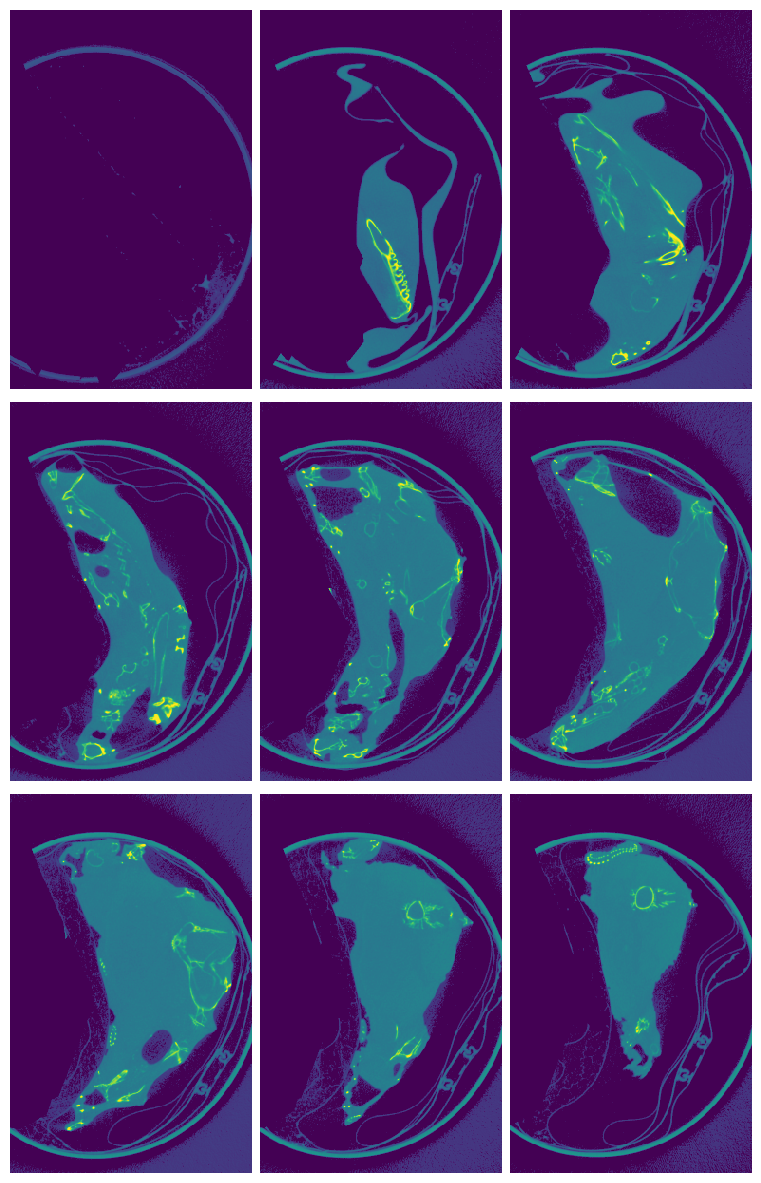

In [111]:
if scale == 1:
    imgs = segment.load_images(imgs_path, file_suffix='.tif')
    imgs = util.img_as_ubyte(imgs)
else:
    imgs = load_rescaled_images(
        imgs_path, scale, file_suffix='.tif', convert_to_unit8=True)
print('Data type: ', imgs.dtype)
if slice_crop is not None:
    imgs = imgs[slice_crop[0]:slice_crop[1], ...]
fig, axes = view.plot_slices(
    imgs,
    nslices=9,
    print_slices=True,
    imgs_per_row=3,
    fig_w=7.5,
    dpi=100
)

## Radial mask

Creating radial mask...
--> Calculating average image...
--> Finding edges...
--> Fitting circle to edges...
(400, 255)


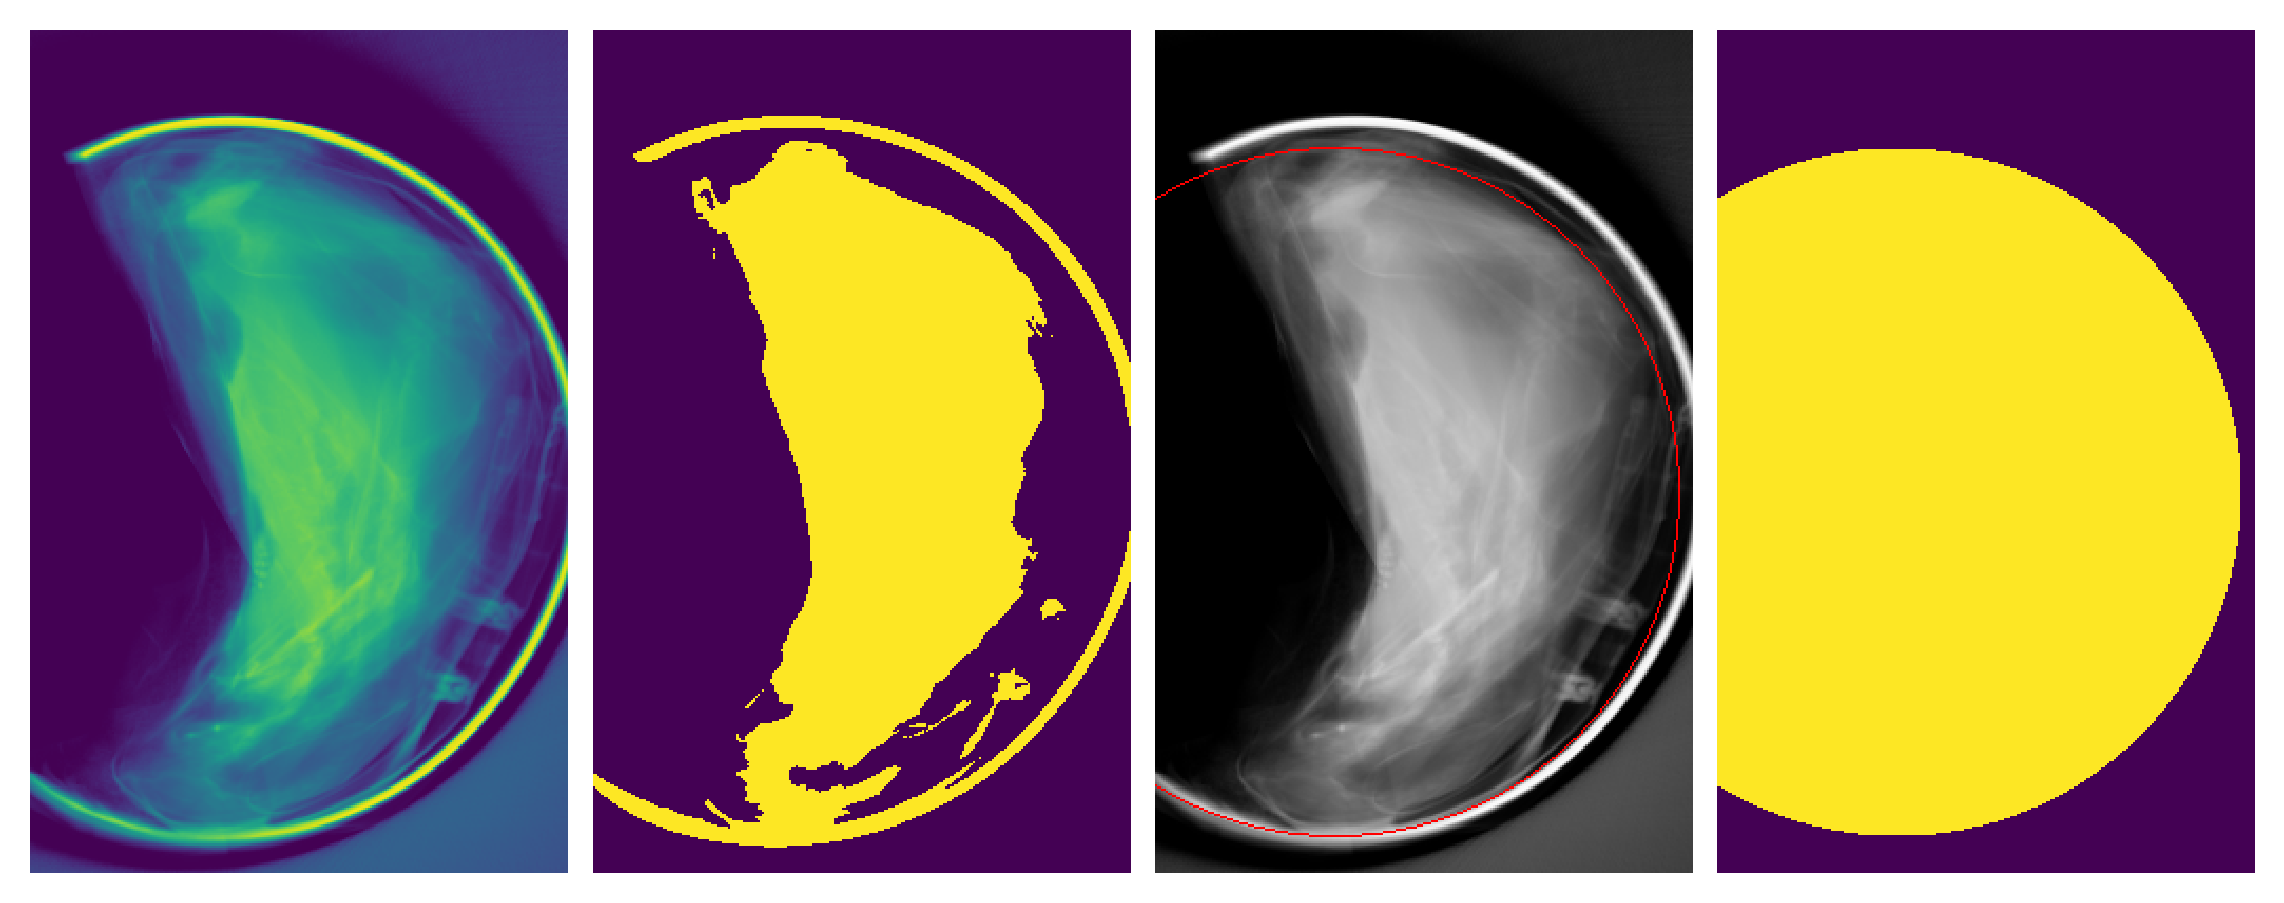

In [112]:
print('Creating radial mask...')
print('--> Calculating average image...')
img_avg = np.mean(imgs, axis=0)
print('--> Finding edges...')
threshold = filters.threshold_otsu(img_avg)
# Segment images with threshold values
img_avg_bw = segment.isolate_classes(img_avg, threshold, intensity_step=255)
# Detect edges in image
edges = feature.canny(img_avg_bw)
print('--> Fitting circle to edges...')
cx, cy, r = segment.fit_circle_to_edges(edges)
if scale == 1:
    r -= int(20*scale)
    cx += int(17*scale)
    cy -= int(8*scale)
elif scale == 0.5:
    r -= 9
    # cx += 2
    cy += 4
elif scale == 0.25:
    r -= 2
    cx += 1
    # cy += 4
# Draw circle
img_avg = exposure.rescale_intensity(img_avg)
img_avg = util.img_as_ubyte(img_avg)
edges_w_circle = color.gray2rgb(img_avg)
rows, cols = draw.circle_perimeter(cy, cx, r, shape=img_avg.shape)
edges_w_circle[rows, cols] = (255, 0, 0)
# Draw circular mask
rows, cols = draw.disk((cy, cx), r, shape=img_avg_bw.shape)
mask = np.zeros_like(img_avg_bw)
mask[rows, cols] = 1
print(mask.shape)
fig, axes = view.images([img_avg, img_avg_bw, edges_w_circle, mask], dpi=300)

--> Plotting images: [  0  62 124 187 249 311 374 436 499]


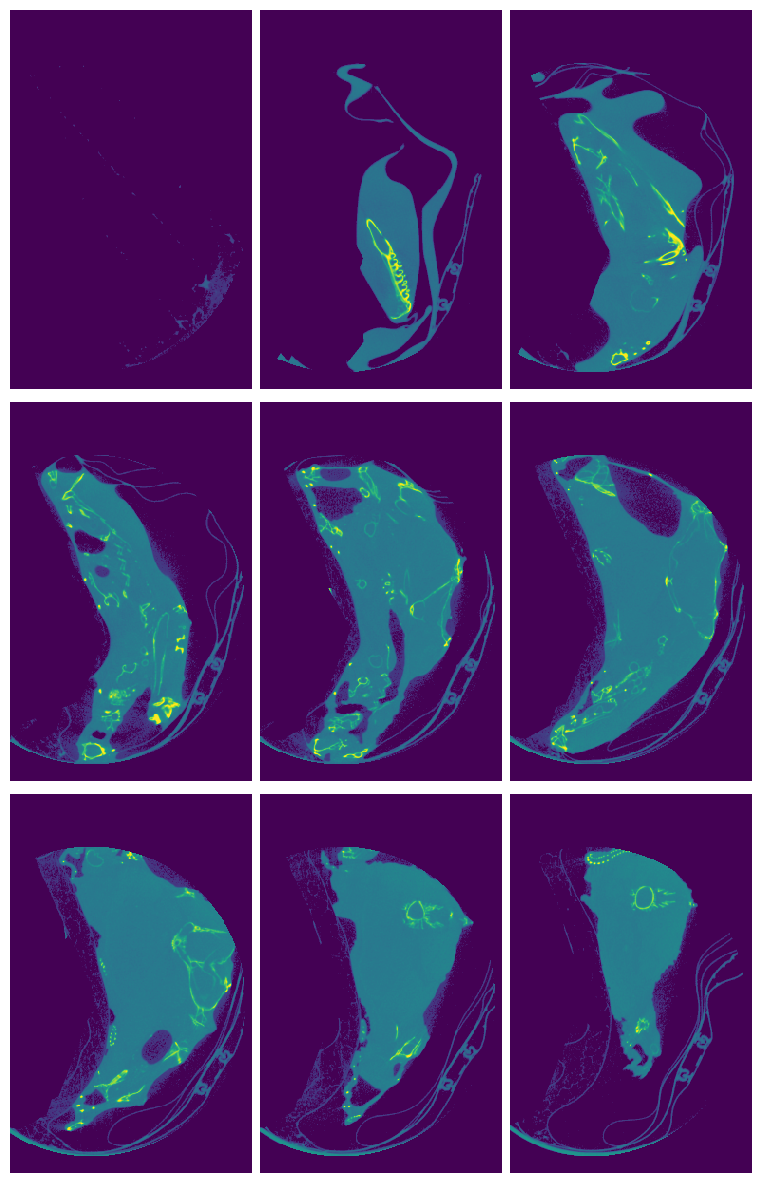

In [113]:
imgs_masked = mask*imgs
fig, axes = view.plot_slices(
    imgs_masked,
    nslices=9,
    print_slices=True,
    imgs_per_row=3,
    fig_w=7.5,
    dpi=100
)

In [114]:
print('Applying median filter...')
imgs_masked = filters.median(imgs_masked)
print('--> Images filtered.')

Applying median filter...
--> Images filtered.


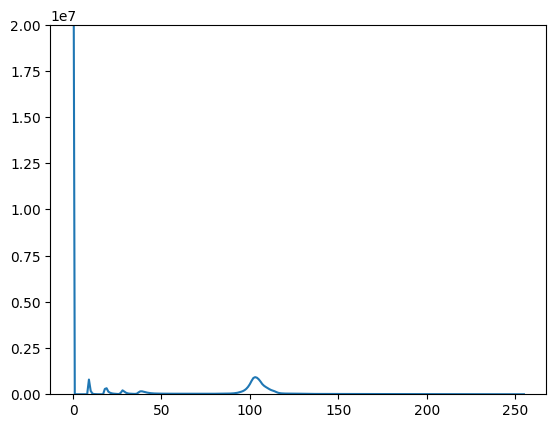

In [115]:
hist, bins_centers = exposure.histogram(imgs_masked)
fig, ax = plt.subplots()
ax.plot(bins_centers, hist)
ax.set_ylim([0, 2e7])
plt.show()

## Semantic seg

--> Plotting images: [  0  62 124 187 249 311 374 436 499]


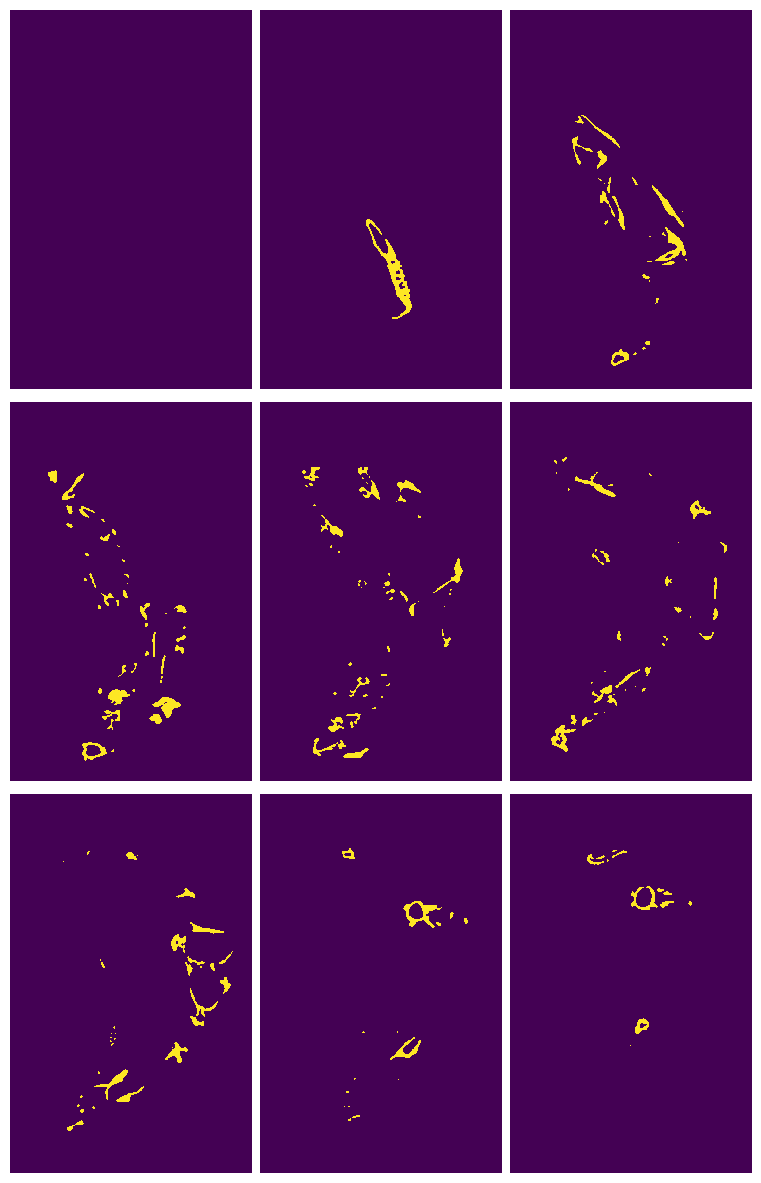

In [116]:
thresholds = [135]
imgs_semantic = segment.isolate_classes(imgs_masked, thresholds)
fig, axes = view.plot_slices(
    imgs_semantic,
    nslices=9,
    print_slices=True,
    imgs_per_row=3,
    fig_w=7.5,
    dpi=100
)

In [117]:
pts = np.array(np.nonzero(imgs_semantic))
pts.shape

(3, 645988)

## Clean image

--> Plotting images: [  0  62 124 187 249 311 374 436 499]


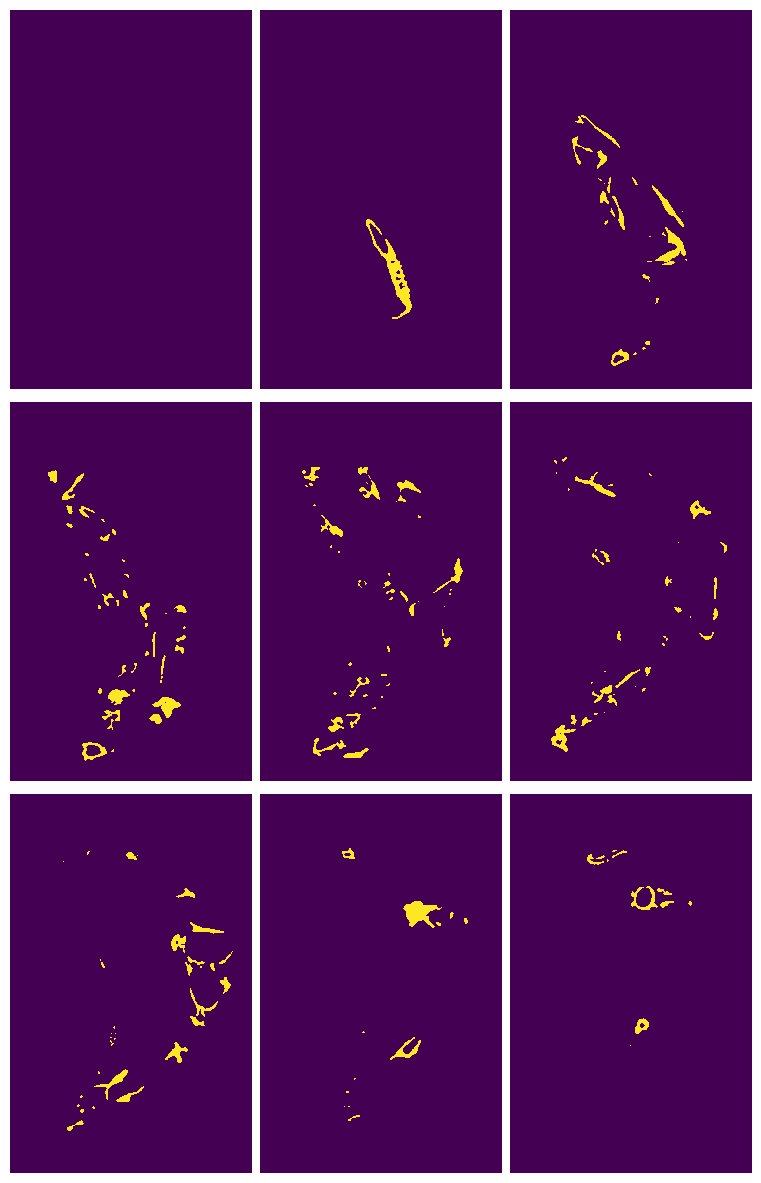

In [118]:
imgs_cleaned = morphology.binary_closing(imgs_semantic)
imgs_cleaned = ndi.binary_fill_holes(imgs_cleaned)
imgs_cleaned = morphology.remove_small_objects(imgs_cleaned, 10)
fig, axes = view.plot_slices(
    imgs_cleaned,
    nslices=9,
    print_slices=True,
    imgs_per_row=3,
    fig_w=7.5,
    dpi=100
)

## Segment

Segmenting images...
--> Segmentation complete. 123 particle(s) segmented.
--> Plotting images: [  0  62 124 187 249 311 374 436 499]


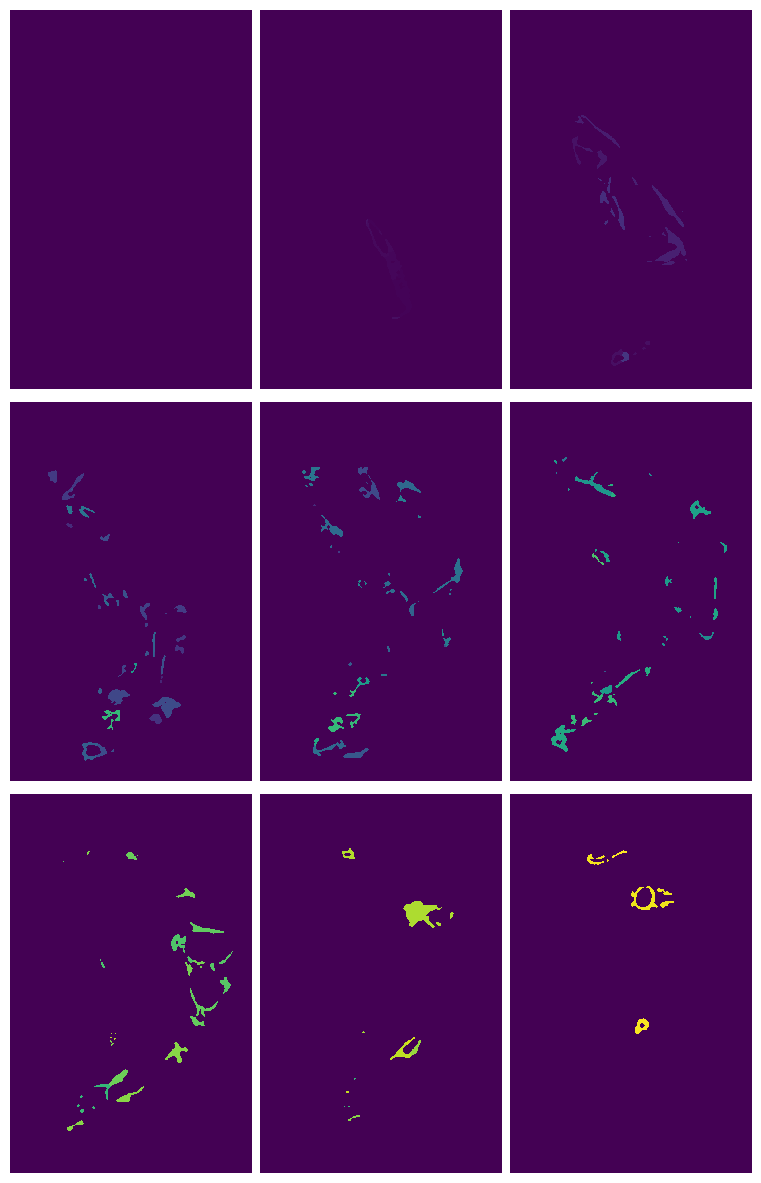

In [119]:
if run_seg:
    imgs_seg = segment.watershed_segment(imgs_cleaned, min_peak_distance=msd)
    if merge_file_path is not None:
        imgs_seg = segment.manual_merge(imgs_seg, merge_file_path)
    fig, axes = view.plot_slices(
        imgs_seg,
        nslices=9,
        print_slices=True,
        imgs_per_row=3,
        fig_w=7.5,
        dpi=100
    )
else:
    imgs_seg = imgs_semantic
    msd = ''

In [120]:
np.unique(imgs_seg).shape

(124,)

### Save meshes

In [121]:
if run_seg:
    fn = f'angler-fish-{scale}x-{msd}msd{suffix}'
else:
    fn = f'angler-fish-{scale}x-binary{suffix}'
segment.save_as_stl_files(
    imgs_seg,
    save_dir_path,
    fn,
)


Generating surface meshes...
Surface mesh not created for particle 47. Particle likely too small. Error:  No surface found at the given iso value.
Surface mesh not created for particle 83. Particle likely too small. Error:  No surface found at the given iso value.
Surface mesh not created for particle 87. Particle likely too small. Error:  No surface found at the given iso value.
Surface mesh not created for particle 92. Particle likely too small. Error:  No surface found at the given iso value.
Surface mesh not created for particle 102. Particle likely too small. Error:  No surface found at the given iso value.
Surface mesh not created for particle 113. Particle likely too small. Error:  No surface found at the given iso value.
Surface mesh not created for particle 116. Particle likely too small. Error:  No surface found at the given iso value.
Surface mesh not created for particle 119. Particle likely too small. Error:  No surface found at the given iso value.
--> 115 STL file(s) wri